## 배터리 최적화(LP최적화)

### 데이터 전처리

In [58]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd


# .mat 파일 로드
data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten().reshape(-1, 1)

cloudyDay = data['cloudyDay'].flatten().reshape(-1, 1)

clearDay = data['clearDay'].flatten().reshape(-1, 1)

loadData = data['loadData'][:, 2].reshape(-1, 1)

costData = data['costData'].flatten().reshape(-1, 1)

print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(cloudyDay), "차원" , cloudyDay.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )



자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)


### 데이터 처리

In [92]:
import numpy as np
import matlab.engine
import numpy as np

# Load Power Data from Existing PV array
# Assuming pvLoadPriceData is already loaded from file

# Set up Optimization Parameters
numDays = 1 # Number of consecutive days
FinalWeight = 1.0  # Final weight on energy storage
timeOptimize = 5  # Time step for optimization [min]

# Battery/PV parameters
panelArea = 2500
panelEff = 0.3

battEnergy = 2500 * 3.6e6
Einit = 0.5 * battEnergy
batteryMinMaxEmax = 0.8 * battEnergy
batteryMinMaxEmin = 0.2 * battEnergy
batteryMinMaxPmin = -400e3
batteryMinMaxPmax = 400e3

# Rescale data to align with desired time steps
stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))

cloudyPpv = panelArea * panelEff * np.tile(cloudyDay[1::stepAdjust], (numDays, 1))
clearPpv = panelArea * panelEff * np.tile(clearDay[1::stepAdjust], (numDays, 1))

# Adjust and Select Loading
loadSelect = 1
loadBase = 350e3
loadFluc = np.tile(loadData[1::stepAdjust], (numDays, 1)) + loadBase

# # Grid Price Values [$/kWh]
C = np.tile(costData[1::stepAdjust], (numDays, 1))

# Select Desired Data for Optimization
Ppv = clearPpv
# Ppv = cloudyPpv
Pload = loadFluc

# Setup Time Vectors
dt = timeOptimize * 60.0
N = numDays * (len(time[::stepAdjust]) - 1) * 1.0
tvec = np.arange(1, N + 1) * dt

print(type(N))
print(type(dt))
print(type(Ppv))
# NumPy 배열을 MATLAB으로 전달
Ppv = matlab.double(Ppv.tolist())
print(type(Pload))
# NumPy 배열을 MATLAB으로 전달
Pload = matlab.double(Pload.tolist())
print(type(Einit))
print(type(C))
# NumPy 배열을 MATLAB으로 전달
C = matlab.double(C.tolist())
print(type(FinalWeight))
print(type(batteryMinMaxEmax))
print(type(batteryMinMaxEmin))
print(type(batteryMinMaxPmin))
print(type(batteryMinMaxPmax))

# # MATLAB Engine 시작
eng = matlab.engine.start_matlab()

result = eng.battSolarOptimize(N, dt, Ppv, Pload, Einit, C, FinalWeight, batteryMinMaxEmax, batteryMinMaxEmin, batteryMinMaxPmin, batteryMinMaxPmax, nargout=3)
Pgrid = np.array(result[0])
Pbatt = np.array(result[1])
Ebatt = np.array(result[2])

eng.quit()

/var/folders/4j/gkyhxcv573j8gxl2r220cymm0000gn/T/ipykernel_15161/1429196818.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))


<class 'float'>
<class 'float'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


### 그래프 출력

Text(0, 0.5, 'PV')

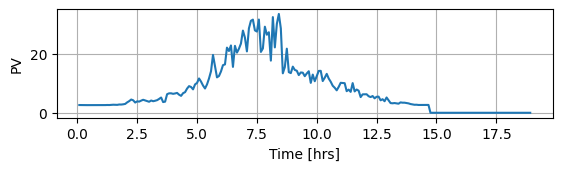

In [60]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Ppv * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('PV')

Text(0, 0.5, 'ESS')

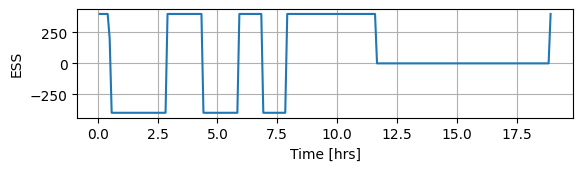

In [84]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pbatt * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('ESS')

Text(0, 0.5, 'Grid')

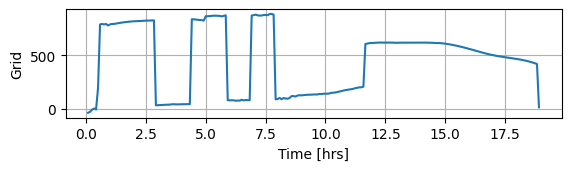

In [85]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pgrid * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid')

Text(0, 0.5, 'Load')

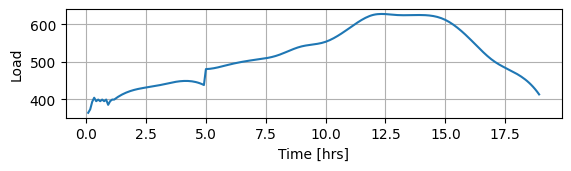

In [86]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pload * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Load')

Text(0, 0.5, 'Grid Price [$/kWh]')

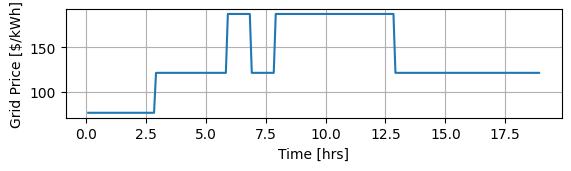

In [87]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)

plt.subplot(3, 1, 1)
# Assuming C is grid price
plt.plot(thour, C)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

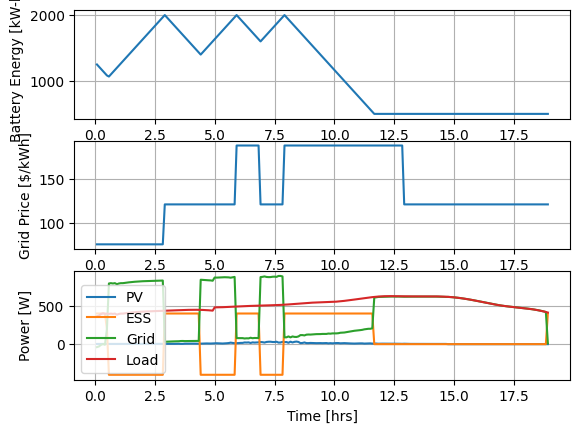

In [88]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Ebatt / 3.6e6)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Battery Energy [kW-h]')

plt.subplot(3, 1, 2)
# Assuming C is grid price
plt.plot(thour, C)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

plt.subplot(3, 1, 3)
# Assuming Ppv, Pbatt, Pgrid, Pload are obtained from battSolarOptimize
plt.plot(thour, Ppv / 1e3, thour, Pbatt / 1e3, thour, Pgrid / 1e3, thour, Pload / 1e3)
plt.grid(True)
plt.legend(['PV', 'ESS', 'Grid', 'Load'])
plt.xlabel('Time [hrs]')
plt.ylabel('Power [W]')

plt.show()


### 비용 계산

In [93]:
cumulativeCost = np.cumsum(Pgrid * (dt / 3600) * C)

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

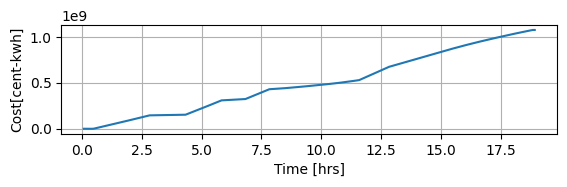

In [94]:
plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, cumulativeCost)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

In [96]:
cumulativeCost[-1] * 10e-6

10751.860841594556